## Kaggle Competition: Cancer Detection

#### Standard Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split

#### Libraries for working with images

In [2]:
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

### Keras libraries

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [4]:
print(tf.__version__)


2.17.0


In [5]:
loc_labels = ("ML2 Projects/CNN_Cancer_Detection/train_labels.csv")
df_labels = pd.read_csv(loc_labels)


In [6]:
print(df_labels.shape[0])
df_labels.head()

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


#### Converting a tif file to numpy array (test with 1st image)

In [6]:
print(df_labels.id.iloc[0])
loc = "ML2 Projects/CNN_Cancer_Detection/train/"
loc_img = loc+df_labels.id.iloc[0]+'.tif'
img = Image.open(loc_img)
img_array = np.array(img)
print(img_array[0][0:5])
print(img_array.shape)

f38a6374c348f90b587e046aac6079959adf3835
[[246 246 244]
 [247 247 245]
 [249 248 246]
 [250 249 247]
 [250 249 247]]
(96, 96, 3)


### Convert the train images to a numpy array (100,000 images convert to a numpy matrix)
#### After multiple crashes of google colab and pc (150k,100k,50k), experimenting with just 20k images.

In [7]:
img_list = []
loc = "ML2 Projects/CNN_Cancer_Detection/train/"
for i in range(20000):
    loc_img = loc+df_labels.id.iloc[i]+'.tif'
    img = Image.open(loc_img)
    img_list.append(np.array(img))


In [8]:
images = np.array(img_list)

In [9]:
labels = df_labels['label'].iloc[0:20000]

### Lets check the shape for images and labels. Also lets check the first 2 entries of labels

In [10]:
print(images.shape)
print(labels.shape)
print(labels.head(4))

(20000, 96, 96, 3)
(20000,)
0    0
1    1
2    0
3    0
Name: label, dtype: int64


### Lets view the 1st 10 images with the labels: 1 for Cancer detected, 0 for no cancer detected

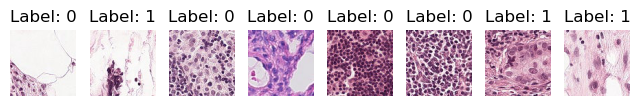

In [12]:
plt.figure(figsize=(8, 8))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()


#### Marking down this since it took a long time to convert the file to csv and created a 28 gb file
##### images.tofile('cancer_train.csv',sep=',',format='%10.5f')

#### Lets check the distribution of 0 and 1 in the labels, 40.4% of the labels are positive cases.
#### Also from the Category counts we can see that there are no Na's or missing values which is great.

Category Counts: label
0    11962
1     8038
Name: count, dtype: int64
% Positive Labels: 0.4019


<Axes: xlabel='label'>

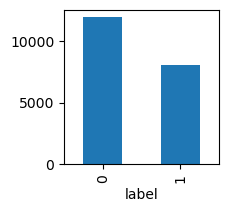

In [13]:
plt.figure(figsize=(2, 2))
print("Category Counts:", labels.value_counts())
print("% Positive Labels:", labels.value_counts()[1]/(labels.value_counts()[1]+labels.value_counts()[0]))
labels.value_counts().plot(kind='bar')

#### Split the data set into training and validation sets

In [11]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)

#### Lets scale the dataset between 0 and 1

In [12]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#### Lets check the train and test datasets


In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16000, 96, 96, 3)
(16000,)
(4000, 96, 96, 3)
(4000,)


### CNN Architecture
#### Refrences: 1. https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa  
#### 2. Recommendations by Professor Geena Kim


#### Based on the above recommendations and some readings, I will go with a Model Architecture specified below:
#### The reason I am not adding more layers is because the training speed, I have expired my GPU time with Colab so need to train with my PC.
##### 1. Conv Layer (16,(3,3), activation = 'relu')
##### 2. Conv Layer (32,(3,3),activation = 'relu')
##### 3. MaxPooling (2,2)
##### 4. Dense Layer (512, activation='relu')##### 5. Output Layer (2, activation = 'sigmoid'))
.

#### Lets add callback for eary stopping

In [14]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

In [15]:
model=Sequential()
model.add(keras.Input(shape=(96,96,3)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


### Hyperparameters...
#### Los = cross entropy since this is a classification problem
#### metrics = accuracy
#### Lets use adam as our optimizer

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#### Model Summary

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    34,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,674,657 (132.27 MB)

 Trainable params: 34,674,657 (132.27 MB)

 Non-trainable params: 0 (0.00 B)

#### Lets go with 40 epochs since in the weekly assignment we saw that 40 epochs got us to the minimum loss
#### For batch size we will keep the default of 32

In [17]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test),callbacks=[callback])


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 456s 857ms/step - accuracy: 0.6943 - loss: 1.2671 - val_accuracy: 0.8037 - val_loss: 0.4539
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 397s 794ms/step - accuracy: 0.8038 - loss: 0.4467 - val_accuracy: 0.7960 - val_loss: 0.4495
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 396s 791ms/step - accuracy: 0.8270 - loss: 0.4003 - val_accuracy: 0.7705 - val_loss: 0.4859
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 403s 805ms/step - accuracy: 0.8877 - loss: 0.2847 - val_accuracy: 0.7763 - val_loss: 0.5289
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 398s 795ms/step - accuracy: 0.9282 - loss: 0.1896 - val_accuracy: 0.7635 - val_loss: 0.8501
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 391s 782ms/step - accuracy: 0.9639 - loss: 0.1052 - val_accuracy: 0.7755 - val_loss: 0.8621
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 396s 790ms/step - accuracy: 0.9829 - loss: 0.0580 - val_accuracy: 0.7805 - val_loss: 1.0133
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 396s 792ms/step - accuracy: 0.9828 -

#### Lets plot the accuracy...Clearly a case of overfitting. Surprisingly validation scores were the best after 1st epoch @ 80%.

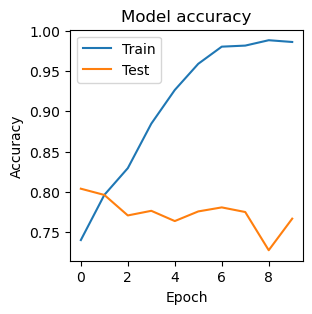

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(3,3))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()


#### Lets plot Loss....Epoch 1 and 2 gave the best scores for Accuracy and Loss for the Validation Sets

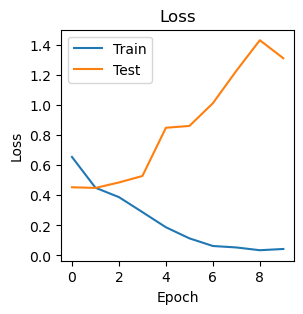

In [37]:
plt.figure(figsize=(3,3))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()


### Lets take another stab by adding 4 convoluted layers and 2 max pooling layers and see the results but with only 4 epochs.

In [31]:
model1=Sequential()
model1.add(keras.Input(shape=(96,96,3)))
model1.add(Conv2D(16, (3, 3), activation='relu'))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(16, (3, 3), activation='relu'))
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))


In [33]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
model1.fit(x_train, y_train, epochs=4, batch_size=32, validation_data=(x_test, y_test),callbacks=[callback])

Epoch 1/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 103s 195ms/step - accuracy: 0.7039 - loss: 0.5867 - val_accuracy: 0.8008 - val_loss: 0.4536
Epoch 2/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 110s 220ms/step - accuracy: 0.7997 - loss: 0.4496 - val_accuracy: 0.8035 - val_loss: 0.4424
Epoch 3/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 100s 200ms/step - accuracy: 0.8146 - loss: 0.4136 - val_accuracy: 0.8163 - val_loss: 0.4253


#### This model gives better validation accuracy and loss @81.6% and 0.4253. The model is also not overfitting and could improve if we had more data. Lets see the accuracy and loss plots

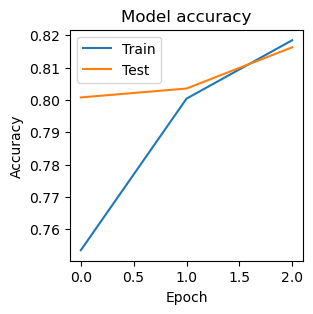

In [35]:
plt.figure(figsize=(3,3))
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()


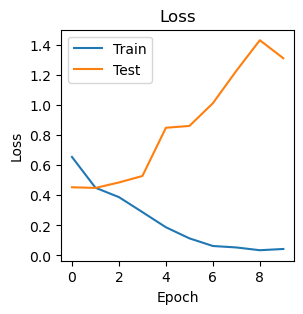

In [38]:
plt.figure(figsize=(3,3))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()


#### Lets make predictions on the test dataset

In [40]:
yhat_val = model1.predict(x_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step


#### Lets look at the last 10 records....8 of the 10 records were predicted correctly which is in line with the 82% validation accuracy

In [57]:
print(yhat_val[-10:])
print(y_test[-10:])

[[0.9172028 ]
 [0.8995446 ]
 [0.11361172]
 [0.89047617]
 [0.47107282]
 [0.8130108 ]
 [0.38824776]
 [0.06758693]
 [0.15976419]
 [0.89768106]]
8273     1
4120     1
4789     1
7096     1
3325     0
13794    1
1526     1
3800     0
18045    0
18272    1
Name: label, dtype: int64


#### Lets download the test dataset and make predictions to upload to kaggle

In [60]:
df = pd.read_csv("ML2 Projects/CNN_Cancer_Detection/sample_submission.csv")


In [62]:
print(df.shape)
df.head()

(57458, 2)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [63]:
img_list = []
loc = "ML2 Projects/CNN_Cancer_Detection/test/"
for i in range(57458):
    loc_img = loc+df.id.iloc[i]+'.tif'
    img = Image.open(loc_img)
    img_list.append(np.array(img))


In [64]:
images = np.array(img_list)

In [68]:
x_test_submission = images.astype('float32') / 255

In [69]:
yhat_test = model1.predict(x_test_submission)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step


In [70]:
yhat_test[0:10]

array([[0.05072165],
       [0.68870926],
       [0.02169199],
       [0.3768099 ],
       [0.3149076 ],
       [0.34097722],
       [0.84291583],
       [0.790331  ],
       [0.15366443],
       [0.8382478 ]], dtype=float32)

In [73]:
yhat_test[yhat_test >= 0.5] = 1
yhat_test[yhat_test <= 0.5] = 0
print(yhat_test[0:10])

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


#### Lets get the submission file ready

In [75]:
df.loc[:, 'label'] = yhat_test
df.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
6,aa0307865281d4484ddf8c637c348292968b93a7,1
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,1
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,1


In [76]:
df.to_csv("cnn_submission.csv")


#### Below is the score for my submission...as expected it is 79%. With better processing power and a more complex model I could have definitely got a better score.
#### 80% score is just be utilizing 20k or 9% of the dataset which is pretty decent.

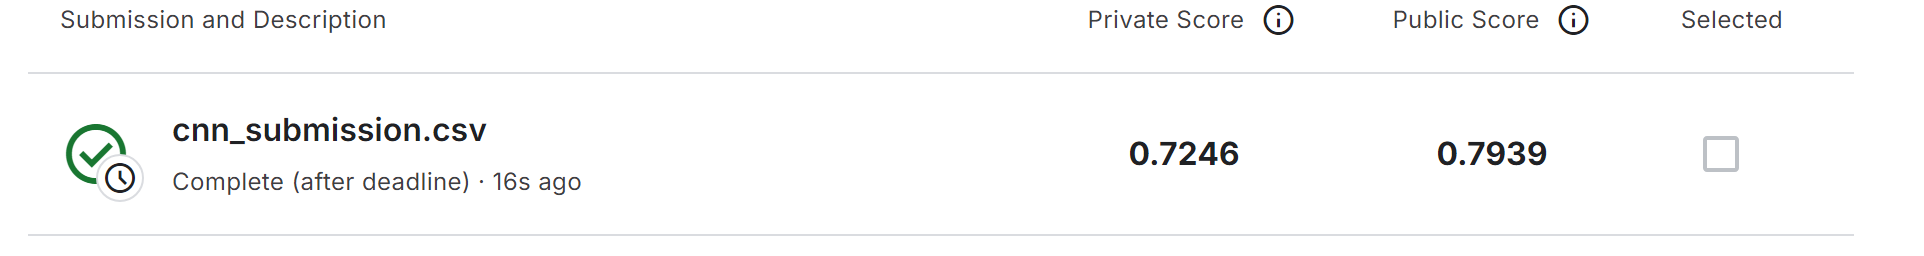

#### Project Summary

#### In this project we had to predict whether a patient has cancer or not based on digital pathology scans. We had a training data of almost 220k images with app. 40% of the images labeled positive for cancer. For this I built a Convoluted Neural Network with 4 convoluted layers, 2 max pooling layers and 1 dense layer. The accuracy of the model was 81.6% on the validation set and 79.4% on the test data provided by Kaggle.

### Key Takeaways
#### The biggest takeaway from this project was the challenge of working on this big dataset. Google Colab crashed on me a few times and then gave the message that I am out of GPU usage. My Jupyter notebook crashed multiple times and gave the error meesage " Out of Memory". Eventually I had to build the model on 20k images (only 9% of the data) and a score of 79% considering that is pretty decent. I am sure that with more processing power I could have used 100% of the training data and experimented with more complex architectures and higher epochs to get a much better score.